In [1]:
import torch
import numpy as np
import random
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import pandas
import time

###  读取数据集

In [2]:
## 划分数据集
def sliding_window(seq,window_size):
    result=[]
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result

data=np.load("./pems-traffic-flow/PEMS04.npz")  # npz是二进制格式

data=data["data"][:,0:1,0:1]
# data
## 归一化
dmin,dmax=data.min(),data.max()
data=(data-dmin)/(dmax-dmin)
sensordata_num,sensor_num,_ = data.shape  
# print(data.shape)  #(16992,1,1)

train_set,test_set = [],[]  
for  i in range(sensor_num) :  
    train_seq = data[:int(sensordata_num*0.8),i,:]  
    test_seq = data[int(sensordata_num*0.8):,i,:]  
    train_set += sliding_window(train_seq,window_size=13)  
    test_set += sliding_window(test_seq,window_size=13)  
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()  
print(train_set.shape,test_set.shape)    #（13580,13)
print(train_set,test_set)                #(3386,13)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


### 初始化模型+优化器

In [3]:
device = 'cuda'  
model = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(32, 1), nn.LeakyReLU()).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(out_linear.parameters()), lr=0.0001)

### mape函数

In [4]:
def mape(y_true, y_pred):  
    y_true, y_pred = np.array(y_true), np.array(y_pred)  
    non_zero_index = (y_true > 0)  
    y_true = y_true[non_zero_index]  
    y_pred = y_pred[non_zero_index]  
  
    mape = np.abs((y_true - y_pred) / y_true)  
    mape[np.isinf(mape)] = 0  
    return np.mean(mape) * 100  

### next_batch函数

In [5]:
def next_batch(data, batch_size):  
    data_length = len(data)  
    num_batches = math.ceil(data_length / batch_size)  
    for batch_index in range(num_batches):  
        start_index = batch_index * batch_size  
        end_index = min((batch_index + 1) * batch_size, data_length)  
        yield data[start_index:end_index]

### 开始训练

In [6]:
from sklearn.utils import shuffle 
import math 
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image 
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [7]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=256):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = model(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = out_linear(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
       
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=256):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = model(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = out_linear(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))

batch 1, train_loss 0.145161,Time used 0.711760s
batch 2, train_loss 0.159379,Time used 0.004960s
batch 3, train_loss 0.157479,Time used 0.002976s
batch 4, train_loss 0.161151,Time used 0.002975s
batch 5, train_loss 0.155898,Time used 0.002976s
batch 6, train_loss 0.160776,Time used 0.002972s
batch 7, train_loss 0.147301,Time used 0.003472s
batch 8, train_loss 0.136342,Time used 0.002977s
batch 9, train_loss 0.150729,Time used 0.002976s
batch 10, train_loss 0.153755,Time used 0.002976s
batch 11, train_loss 0.153493,Time used 0.002976s
batch 12, train_loss 0.153272,Time used 0.002975s
batch 13, train_loss 0.142501,Time used 0.002976s
batch 14, train_loss 0.151281,Time used 0.002976s
batch 15, train_loss 0.125219,Time used 0.003968s
batch 16, train_loss 0.145576,Time used 0.004960s
batch 17, train_loss 0.130294,Time used 0.003472s
batch 18, train_loss 0.137121,Time used 0.013887s
batch 19, train_loss 0.120249,Time used 0.003472s
batch 20, train_loss 0.137565,Time used 0.002983s
batch 21,

batch 161, train_loss 0.057107,Time used 0.002976s
batch 162, train_loss 0.080219,Time used 0.003962s
batch 163, train_loss 0.059348,Time used 0.002976s
batch 164, train_loss 0.057792,Time used 0.002976s
batch 165, train_loss 0.050140,Time used 0.002977s
batch 166, train_loss 0.053722,Time used 0.002976s
batch 167, train_loss 0.053536,Time used 0.003472s
batch 168, train_loss 0.059112,Time used 0.003472s
batch 169, train_loss 0.056443,Time used 0.003472s
batch 170, train_loss 0.055509,Time used 0.002977s
batch 171, train_loss 0.059968,Time used 0.003464s
batch 172, train_loss 0.058165,Time used 0.004961s
batch 173, train_loss 0.061556,Time used 0.002976s
batch 174, train_loss 0.053379,Time used 0.002981s
batch 175, train_loss 0.059490,Time used 0.002976s
batch 176, train_loss 0.056657,Time used 0.003967s
batch 177, train_loss 0.060017,Time used 0.002976s
batch 178, train_loss 0.056417,Time used 0.003472s
batch 179, train_loss 0.057230,Time used 0.002974s
batch 180, train_loss 0.053545,

batch 316, train_loss 0.046483,Time used 0.002976s
batch 317, train_loss 0.044602,Time used 0.002975s
batch 318, train_loss 0.045278,Time used 0.002971s
batch 319, train_loss 0.048038,Time used 0.003472s
batch 320, train_loss 0.046197,Time used 0.003471s
batch 321, train_loss 0.050188,Time used 0.003477s
batch 322, train_loss 0.048153,Time used 0.002976s
batch 323, train_loss 0.046340,Time used 0.003472s
batch 324, train_loss 0.047764,Time used 0.002976s
batch 325, train_loss 0.049249,Time used 0.003968s
batch 326, train_loss 0.045566,Time used 0.002976s
batch 327, train_loss 0.050923,Time used 0.002977s
batch 328, train_loss 0.047010,Time used 0.002976s
batch 329, train_loss 0.048821,Time used 0.002977s
batch 330, train_loss 0.045653,Time used 0.002976s
batch 331, train_loss 0.046087,Time used 0.003472s
batch 332, train_loss 0.044204,Time used 0.002976s
batch 333, train_loss 0.045753,Time used 0.002976s
batch 334, train_loss 0.046542,Time used 0.002976s
batch 335, train_loss 0.043566,

batch 473, train_loss 0.036171,Time used 0.002977s
batch 474, train_loss 0.036570,Time used 0.002976s
batch 475, train_loss 0.034739,Time used 0.002480s
batch 476, train_loss 0.034863,Time used 0.002480s
batch 477, train_loss 0.036794,Time used 0.002480s
batch 478, train_loss 0.036849,Time used 0.003968s
batch 479, train_loss 0.040156,Time used 0.002972s
batch 480, train_loss 0.030997,Time used 0.002480s
batch 481, train_loss 0.031372,Time used 0.002976s
batch 482, train_loss 0.033396,Time used 0.002480s
batch 483, train_loss 0.033054,Time used 0.003471s
batch 484, train_loss 0.032972,Time used 0.002977s
batch 485, train_loss 0.033962,Time used 0.003471s
batch 486, train_loss 0.046084,Time used 0.002480s
batch 487, train_loss 0.035847,Time used 0.002976s
batch 488, train_loss 0.033686,Time used 0.003467s
batch 489, train_loss 0.033450,Time used 0.003472s
batch 490, train_loss 0.031653,Time used 0.003479s
batch 491, train_loss 0.029675,Time used 0.002976s
batch 492, train_loss 0.033505,

batch 628, train_loss 0.005155,Time used 0.002976s
batch 629, train_loss 0.005794,Time used 0.002976s
batch 630, train_loss 0.006065,Time used 0.002976s
batch 631, train_loss 0.005911,Time used 0.002976s
batch 632, train_loss 0.004491,Time used 0.003472s
batch 633, train_loss 0.004333,Time used 0.003471s
batch 634, train_loss 0.005609,Time used 0.004958s
batch 635, train_loss 0.005627,Time used 0.003472s
batch 636, train_loss 0.005245,Time used 0.003477s
batch 637, train_loss 0.006403,Time used 0.003461s
batch 638, train_loss 0.005098,Time used 0.003472s
batch 639, train_loss 0.005813,Time used 0.012401s
batch 640, train_loss 0.004605,Time used 0.002976s
batch 641, train_loss 0.005061,Time used 0.003472s
batch 642, train_loss 0.004721,Time used 0.003472s
batch 643, train_loss 0.005237,Time used 0.002976s
batch 644, train_loss 0.006723,Time used 0.003473s
batch 645, train_loss 0.006294,Time used 0.002977s
batch 646, train_loss 0.005313,Time used 0.003473s
batch 647, train_loss 0.004970,

batch 786, train_loss 0.005751,Time used 0.002479s
batch 787, train_loss 0.004019,Time used 0.002977s
batch 788, train_loss 0.005856,Time used 0.002964s
batch 789, train_loss 0.005294,Time used 0.002976s
batch 790, train_loss 0.004815,Time used 0.002976s
batch 791, train_loss 0.005804,Time used 0.003472s
batch 792, train_loss 0.005038,Time used 0.002480s
batch 793, train_loss 0.005011,Time used 0.002976s
batch 794, train_loss 0.007878,Time used 0.002976s
batch 795, train_loss 0.005695,Time used 0.002976s
batch 796, train_loss 0.005206,Time used 0.002976s
batch 797, train_loss 0.005893,Time used 0.002976s
batch 798, train_loss 0.006606,Time used 0.004464s
batch 799, train_loss 0.006114,Time used 0.002969s
batch 800, train_loss 0.004988,Time used 0.003472s
***************************test_batch 800, test_rmse_loss 0.072956,test_mae_loss 0.054002,test_mape_loss 17.262130,Time used 0.009920s
batch 801, train_loss 0.004900,Time used 0.012400s
batch 802, train_loss 0.004233,Time used 0.002976

batch 941, train_loss 0.005730,Time used 0.002479s
batch 942, train_loss 0.006269,Time used 0.002976s
batch 943, train_loss 0.006598,Time used 0.002977s
batch 944, train_loss 0.004651,Time used 0.003469s
batch 945, train_loss 0.004459,Time used 0.002480s
batch 946, train_loss 0.004600,Time used 0.002480s
batch 947, train_loss 0.005845,Time used 0.002971s
batch 948, train_loss 0.004714,Time used 0.002976s
batch 949, train_loss 0.005554,Time used 0.003472s
batch 950, train_loss 0.004313,Time used 0.002976s
batch 951, train_loss 0.004403,Time used 0.002971s
batch 952, train_loss 0.005698,Time used 0.002480s
batch 953, train_loss 0.005452,Time used 0.002480s
batch 954, train_loss 0.004056,Time used 0.002976s
batch 955, train_loss 0.004732,Time used 0.002976s
batch 956, train_loss 0.005144,Time used 0.002976s
batch 957, train_loss 0.005352,Time used 0.002480s
batch 958, train_loss 0.004391,Time used 0.002976s
batch 959, train_loss 0.005253,Time used 0.003472s
batch 960, train_loss 0.005514,

batch 1097, train_loss 0.004778,Time used 0.002976s
batch 1098, train_loss 0.004805,Time used 0.003472s
batch 1099, train_loss 0.003941,Time used 0.003968s
batch 1100, train_loss 0.005867,Time used 0.003473s
***************************test_batch 1100, test_rmse_loss 0.070904,test_mae_loss 0.052299,test_mape_loss 16.795571,Time used 0.011408s
batch 1101, train_loss 0.004931,Time used 0.002976s
batch 1102, train_loss 0.004675,Time used 0.002977s
batch 1103, train_loss 0.004929,Time used 0.002976s
batch 1104, train_loss 0.005539,Time used 0.004476s
batch 1105, train_loss 0.005394,Time used 0.003472s
batch 1106, train_loss 0.004709,Time used 0.002976s
batch 1107, train_loss 0.004990,Time used 0.003968s
batch 1108, train_loss 0.005728,Time used 0.002976s
batch 1109, train_loss 0.006342,Time used 0.002975s
batch 1110, train_loss 0.005649,Time used 0.002976s
batch 1111, train_loss 0.005308,Time used 0.002976s
batch 1112, train_loss 0.006119,Time used 0.002480s
batch 1113, train_loss 0.005399,

batch 1249, train_loss 0.004703,Time used 0.003472s
batch 1250, train_loss 0.005436,Time used 0.002976s
batch 1251, train_loss 0.005203,Time used 0.003472s
batch 1252, train_loss 0.004377,Time used 0.003472s
batch 1253, train_loss 0.005476,Time used 0.003471s
batch 1254, train_loss 0.004883,Time used 0.002975s
batch 1255, train_loss 0.004720,Time used 0.003472s
batch 1256, train_loss 0.003941,Time used 0.002480s
batch 1257, train_loss 0.004446,Time used 0.002976s
batch 1258, train_loss 0.005032,Time used 0.003471s
batch 1259, train_loss 0.005453,Time used 0.003472s
batch 1260, train_loss 0.004811,Time used 0.003472s
batch 1261, train_loss 0.005928,Time used 0.002976s
batch 1262, train_loss 0.005314,Time used 0.002976s
batch 1263, train_loss 0.005829,Time used 0.002976s
batch 1264, train_loss 0.005398,Time used 0.002977s
batch 1265, train_loss 0.005044,Time used 0.002976s
batch 1266, train_loss 0.004354,Time used 0.004464s
batch 1267, train_loss 0.005141,Time used 0.003472s
batch 1268, 

batch 1401, train_loss 0.005713,Time used 0.002976s
batch 1402, train_loss 0.004504,Time used 0.003968s
batch 1403, train_loss 0.004793,Time used 0.003472s
batch 1404, train_loss 0.011674,Time used 0.002976s
batch 1405, train_loss 0.004797,Time used 0.002975s
batch 1406, train_loss 0.004923,Time used 0.002976s
batch 1407, train_loss 0.004288,Time used 0.002481s
batch 1408, train_loss 0.005586,Time used 0.002976s
batch 1409, train_loss 0.004613,Time used 0.003963s
batch 1410, train_loss 0.004864,Time used 0.002976s
batch 1411, train_loss 0.004978,Time used 0.002982s
batch 1412, train_loss 0.004657,Time used 0.002480s
batch 1413, train_loss 0.004407,Time used 0.002975s
batch 1414, train_loss 0.004194,Time used 0.002976s
batch 1415, train_loss 0.005438,Time used 0.002976s
batch 1416, train_loss 0.004275,Time used 0.002480s
batch 1417, train_loss 0.004657,Time used 0.002975s
batch 1418, train_loss 0.004646,Time used 0.002479s
batch 1419, train_loss 0.005281,Time used 0.002976s
batch 1420, 

batch 1555, train_loss 0.004688,Time used 0.002975s
batch 1556, train_loss 0.004342,Time used 0.002983s
batch 1557, train_loss 0.004998,Time used 0.002976s
batch 1558, train_loss 0.005059,Time used 0.002976s
batch 1559, train_loss 0.004033,Time used 0.002976s
batch 1560, train_loss 0.004166,Time used 0.002976s
batch 1561, train_loss 0.004583,Time used 0.003472s
batch 1562, train_loss 0.004866,Time used 0.002976s
batch 1563, train_loss 0.005614,Time used 0.002975s
batch 1564, train_loss 0.004617,Time used 0.002976s
batch 1565, train_loss 0.005182,Time used 0.002976s
batch 1566, train_loss 0.004796,Time used 0.003459s
batch 1567, train_loss 0.004316,Time used 0.003472s
batch 1568, train_loss 0.004728,Time used 0.003472s
batch 1569, train_loss 0.005326,Time used 0.012400s
batch 1570, train_loss 0.005092,Time used 0.002480s
batch 1571, train_loss 0.004077,Time used 0.002976s
batch 1572, train_loss 0.004091,Time used 0.003472s
batch 1573, train_loss 0.003870,Time used 0.002480s
batch 1574, 

batch 1707, train_loss 0.004690,Time used 0.003471s
batch 1708, train_loss 0.003482,Time used 0.002976s
batch 1709, train_loss 0.003746,Time used 0.002480s
batch 1710, train_loss 0.004766,Time used 0.003472s
batch 1711, train_loss 0.005650,Time used 0.002976s
batch 1712, train_loss 0.004700,Time used 0.002976s
batch 1713, train_loss 0.004153,Time used 0.002976s
batch 1714, train_loss 0.004414,Time used 0.002976s
batch 1715, train_loss 0.004542,Time used 0.002975s
batch 1716, train_loss 0.004431,Time used 0.003472s
batch 1717, train_loss 0.004103,Time used 0.002976s
batch 1718, train_loss 0.004187,Time used 0.003471s
batch 1719, train_loss 0.004428,Time used 0.003472s
batch 1720, train_loss 0.004984,Time used 0.003472s
batch 1721, train_loss 0.003896,Time used 0.003472s
batch 1722, train_loss 0.005043,Time used 0.002976s
batch 1723, train_loss 0.005606,Time used 0.003473s
batch 1724, train_loss 0.005282,Time used 0.003472s
batch 1725, train_loss 0.004953,Time used 0.003969s
batch 1726, 

batch 1861, train_loss 0.003494,Time used 0.002975s
batch 1862, train_loss 0.004239,Time used 0.002976s
batch 1863, train_loss 0.004929,Time used 0.002972s
batch 1864, train_loss 0.003998,Time used 0.002976s
batch 1865, train_loss 0.004788,Time used 0.003467s
batch 1866, train_loss 0.004251,Time used 0.002977s
batch 1867, train_loss 0.003533,Time used 0.003472s
batch 1868, train_loss 0.004382,Time used 0.002976s
batch 1869, train_loss 0.004053,Time used 0.002976s
batch 1870, train_loss 0.006689,Time used 0.003472s
batch 1871, train_loss 0.004131,Time used 0.003968s
batch 1872, train_loss 0.004235,Time used 0.003472s
batch 1873, train_loss 0.005097,Time used 0.004464s
batch 1874, train_loss 0.004530,Time used 0.003472s
batch 1875, train_loss 0.004187,Time used 0.003481s
batch 1876, train_loss 0.004090,Time used 0.002976s
batch 1877, train_loss 0.005071,Time used 0.002976s
batch 1878, train_loss 0.005216,Time used 0.003968s
batch 1879, train_loss 0.004421,Time used 0.002976s
batch 1880, 

batch 2013, train_loss 0.003833,Time used 0.003472s
batch 2014, train_loss 0.003956,Time used 0.002980s
batch 2015, train_loss 0.004468,Time used 0.002976s
batch 2016, train_loss 0.004850,Time used 0.002976s
batch 2017, train_loss 0.004258,Time used 0.003472s
batch 2018, train_loss 0.003859,Time used 0.002971s
batch 2019, train_loss 0.004626,Time used 0.002975s
batch 2020, train_loss 0.004114,Time used 0.002970s
batch 2021, train_loss 0.004783,Time used 0.003460s
batch 2022, train_loss 0.004301,Time used 0.002976s
batch 2023, train_loss 0.004672,Time used 0.002977s
batch 2024, train_loss 0.004391,Time used 0.003471s
batch 2025, train_loss 0.004760,Time used 0.003473s
batch 2026, train_loss 0.005036,Time used 0.002975s
batch 2027, train_loss 0.005813,Time used 0.002481s
batch 2028, train_loss 0.004009,Time used 0.002481s
batch 2029, train_loss 0.004485,Time used 0.002976s
batch 2030, train_loss 0.003762,Time used 0.002976s
batch 2031, train_loss 0.004101,Time used 0.002976s
batch 2032, 

batch 2167, train_loss 0.003976,Time used 0.005451s
batch 2168, train_loss 0.003655,Time used 0.002976s
batch 2169, train_loss 0.004908,Time used 0.003471s
batch 2170, train_loss 0.004143,Time used 0.004462s
batch 2171, train_loss 0.003797,Time used 0.014875s
batch 2172, train_loss 0.003466,Time used 0.002976s
batch 2173, train_loss 0.004205,Time used 0.003471s
batch 2174, train_loss 0.004603,Time used 0.003968s
batch 2175, train_loss 0.003565,Time used 0.003473s
batch 2176, train_loss 0.003913,Time used 0.003472s
batch 2177, train_loss 0.004197,Time used 0.003472s
batch 2178, train_loss 0.004421,Time used 0.003968s
batch 2179, train_loss 0.003829,Time used 0.002976s
batch 2180, train_loss 0.004618,Time used 0.002977s
batch 2181, train_loss 0.004234,Time used 0.003968s
batch 2182, train_loss 0.003693,Time used 0.003968s
batch 2183, train_loss 0.004713,Time used 0.003968s
batch 2184, train_loss 0.003764,Time used 0.003473s
batch 2185, train_loss 0.003795,Time used 0.003472s
batch 2186, 

batch 2319, train_loss 0.004667,Time used 0.002977s
batch 2320, train_loss 0.003742,Time used 0.003472s
batch 2321, train_loss 0.003737,Time used 0.003463s
batch 2322, train_loss 0.002894,Time used 0.003472s
batch 2323, train_loss 0.004519,Time used 0.002976s
batch 2324, train_loss 0.004294,Time used 0.003472s
batch 2325, train_loss 0.003816,Time used 0.011903s
batch 2326, train_loss 0.003826,Time used 0.003472s
batch 2327, train_loss 0.004542,Time used 0.002967s
batch 2328, train_loss 0.004484,Time used 0.002982s
batch 2329, train_loss 0.004396,Time used 0.002976s
batch 2330, train_loss 0.005149,Time used 0.002972s
batch 2331, train_loss 0.004485,Time used 0.002480s
batch 2332, train_loss 0.004339,Time used 0.002971s
batch 2333, train_loss 0.004517,Time used 0.003472s
batch 2334, train_loss 0.004270,Time used 0.002976s
batch 2335, train_loss 0.003323,Time used 0.002480s
batch 2336, train_loss 0.003353,Time used 0.002976s
batch 2337, train_loss 0.003585,Time used 0.002975s
batch 2338, 

batch 2473, train_loss 0.003256,Time used 0.003467s
batch 2474, train_loss 0.004502,Time used 0.002976s
batch 2475, train_loss 0.004842,Time used 0.002481s
batch 2476, train_loss 0.003712,Time used 0.002976s
batch 2477, train_loss 0.003395,Time used 0.003472s
batch 2478, train_loss 0.004446,Time used 0.003472s
batch 2479, train_loss 0.004070,Time used 0.002480s
batch 2480, train_loss 0.004878,Time used 0.002976s
batch 2481, train_loss 0.003993,Time used 0.002980s
batch 2482, train_loss 0.003936,Time used 0.002481s
batch 2483, train_loss 0.004152,Time used 0.002480s
batch 2484, train_loss 0.008660,Time used 0.002976s
batch 2485, train_loss 0.003469,Time used 0.002976s
batch 2486, train_loss 0.003857,Time used 0.003472s
batch 2487, train_loss 0.003805,Time used 0.002977s
batch 2488, train_loss 0.003792,Time used 0.002976s
batch 2489, train_loss 0.004029,Time used 0.002975s
batch 2490, train_loss 0.004049,Time used 0.002976s
batch 2491, train_loss 0.003282,Time used 0.003472s
batch 2492, 

batch 2625, train_loss 0.004614,Time used 0.003472s
batch 2626, train_loss 0.004701,Time used 0.002977s
batch 2627, train_loss 0.005119,Time used 0.003471s
batch 2628, train_loss 0.003024,Time used 0.003472s
batch 2629, train_loss 0.004567,Time used 0.003472s
batch 2630, train_loss 0.004234,Time used 0.003473s
batch 2631, train_loss 0.004488,Time used 0.003473s
batch 2632, train_loss 0.004105,Time used 0.002977s
batch 2633, train_loss 0.003678,Time used 0.002976s
batch 2634, train_loss 0.003855,Time used 0.002976s
batch 2635, train_loss 0.005176,Time used 0.002976s
batch 2636, train_loss 0.004783,Time used 0.002976s
batch 2637, train_loss 0.004225,Time used 0.002977s
batch 2638, train_loss 0.003487,Time used 0.003472s
batch 2639, train_loss 0.004539,Time used 0.002976s
batch 2640, train_loss 0.003855,Time used 0.002972s
batch 2641, train_loss 0.003330,Time used 0.002976s
batch 2642, train_loss 0.003503,Time used 0.003478s
batch 2643, train_loss 0.005100,Time used 0.002485s
batch 2644, 

batch 2779, train_loss 0.004372,Time used 0.002968s
batch 2780, train_loss 0.003882,Time used 0.002976s
batch 2781, train_loss 0.004778,Time used 0.003472s
batch 2782, train_loss 0.003365,Time used 0.002984s
batch 2783, train_loss 0.003887,Time used 0.002975s
batch 2784, train_loss 0.004043,Time used 0.003472s
batch 2785, train_loss 0.004147,Time used 0.002976s
batch 2786, train_loss 0.003175,Time used 0.002973s
batch 2787, train_loss 0.004127,Time used 0.002976s
batch 2788, train_loss 0.002974,Time used 0.002975s
batch 2789, train_loss 0.003505,Time used 0.003473s
batch 2790, train_loss 0.003345,Time used 0.003477s
batch 2791, train_loss 0.004023,Time used 0.002480s
batch 2792, train_loss 0.003431,Time used 0.002976s
batch 2793, train_loss 0.003425,Time used 0.002976s
batch 2794, train_loss 0.003708,Time used 0.002976s
batch 2795, train_loss 0.003108,Time used 0.002976s
batch 2796, train_loss 0.003706,Time used 0.003468s
batch 2797, train_loss 0.004490,Time used 0.002975s
batch 2798, 

batch 2931, train_loss 0.003762,Time used 0.002976s
batch 2932, train_loss 0.003663,Time used 0.003472s
batch 2933, train_loss 0.004062,Time used 0.003472s
batch 2934, train_loss 0.004078,Time used 0.003473s
batch 2935, train_loss 0.003958,Time used 0.004464s
batch 2936, train_loss 0.003446,Time used 0.002976s
batch 2937, train_loss 0.003711,Time used 0.002976s
batch 2938, train_loss 0.003614,Time used 0.012391s
batch 2939, train_loss 0.003639,Time used 0.002480s
batch 2940, train_loss 0.003294,Time used 0.002976s
batch 2941, train_loss 0.003253,Time used 0.002976s
batch 2942, train_loss 0.004356,Time used 0.002975s
batch 2943, train_loss 0.003746,Time used 0.002975s
batch 2944, train_loss 0.004696,Time used 0.002976s
batch 2945, train_loss 0.004332,Time used 0.002976s
batch 2946, train_loss 0.004568,Time used 0.002976s
batch 2947, train_loss 0.004744,Time used 0.002980s
batch 2948, train_loss 0.003944,Time used 0.002976s
batch 2949, train_loss 0.004444,Time used 0.002976s
batch 2950, 

batch 3085, train_loss 0.003502,Time used 0.002976s
batch 3086, train_loss 0.003950,Time used 0.002975s
batch 3087, train_loss 0.004610,Time used 0.003476s
batch 3088, train_loss 0.003439,Time used 0.003472s
batch 3089, train_loss 0.004263,Time used 0.003472s
batch 3090, train_loss 0.004309,Time used 0.002976s
batch 3091, train_loss 0.004049,Time used 0.003472s
batch 3092, train_loss 0.003474,Time used 0.002968s
batch 3093, train_loss 0.004332,Time used 0.002976s
batch 3094, train_loss 0.005038,Time used 0.003472s
batch 3095, train_loss 0.003942,Time used 0.002480s
batch 3096, train_loss 0.003950,Time used 0.003472s
batch 3097, train_loss 0.004488,Time used 0.003968s
batch 3098, train_loss 0.004036,Time used 0.003472s
batch 3099, train_loss 0.003729,Time used 0.003471s
batch 3100, train_loss 0.005085,Time used 0.002976s
***************************test_batch 3100, test_rmse_loss 0.062974,test_mae_loss 0.045260,test_mape_loss 13.649572,Time used 0.010416s
batch 3101, train_loss 0.003657,

batch 3237, train_loss 0.004042,Time used 0.002976s
batch 3238, train_loss 0.004342,Time used 0.002976s
batch 3239, train_loss 0.004457,Time used 0.002976s
batch 3240, train_loss 0.007227,Time used 0.002976s
batch 3241, train_loss 0.003909,Time used 0.002976s
batch 3242, train_loss 0.003837,Time used 0.002973s
batch 3243, train_loss 0.004706,Time used 0.002976s
batch 3244, train_loss 0.004062,Time used 0.002976s
batch 3245, train_loss 0.004408,Time used 0.002480s
batch 3246, train_loss 0.003038,Time used 0.002976s
batch 3247, train_loss 0.003471,Time used 0.002975s
batch 3248, train_loss 0.003395,Time used 0.002976s
batch 3249, train_loss 0.003833,Time used 0.002976s
batch 3250, train_loss 0.003992,Time used 0.002975s
batch 3251, train_loss 0.004469,Time used 0.002976s
batch 3252, train_loss 0.003404,Time used 0.002976s
batch 3253, train_loss 0.004783,Time used 0.002480s
batch 3254, train_loss 0.003284,Time used 0.002976s
batch 3255, train_loss 0.004027,Time used 0.002975s
batch 3256, 

batch 3391, train_loss 0.003794,Time used 0.002479s
batch 3392, train_loss 0.003385,Time used 0.002480s
batch 3393, train_loss 0.003454,Time used 0.002976s
batch 3394, train_loss 0.003720,Time used 0.002971s
batch 3395, train_loss 0.004804,Time used 0.002479s
batch 3396, train_loss 0.004143,Time used 0.002976s
batch 3397, train_loss 0.003118,Time used 0.002976s
batch 3398, train_loss 0.004367,Time used 0.003472s
batch 3399, train_loss 0.003696,Time used 0.002976s
batch 3400, train_loss 0.004367,Time used 0.002976s
***************************test_batch 3400, test_rmse_loss 0.062529,test_mae_loss 0.044984,test_mape_loss 13.703229,Time used 0.022815s
batch 3401, train_loss 0.003425,Time used 0.002975s
batch 3402, train_loss 0.001228,Time used 0.002981s
batch 3403, train_loss 0.003697,Time used 0.002480s
batch 3404, train_loss 0.004784,Time used 0.002976s
batch 3405, train_loss 0.003913,Time used 0.002976s
batch 3406, train_loss 0.003860,Time used 0.003472s
batch 3407, train_loss 0.004575,

batch 3543, train_loss 0.004053,Time used 0.002976s
batch 3544, train_loss 0.004024,Time used 0.003473s
batch 3545, train_loss 0.003437,Time used 0.002976s
batch 3546, train_loss 0.003548,Time used 0.002976s
batch 3547, train_loss 0.003271,Time used 0.002980s
batch 3548, train_loss 0.003462,Time used 0.005456s
batch 3549, train_loss 0.004624,Time used 0.003966s
batch 3550, train_loss 0.003181,Time used 0.002976s
batch 3551, train_loss 0.003284,Time used 0.013391s
batch 3552, train_loss 0.004732,Time used 0.002976s
batch 3553, train_loss 0.004236,Time used 0.002985s
batch 3554, train_loss 0.003509,Time used 0.003472s
batch 3555, train_loss 0.003522,Time used 0.003968s
batch 3556, train_loss 0.004134,Time used 0.002972s
batch 3557, train_loss 0.003412,Time used 0.002976s
batch 3558, train_loss 0.003110,Time used 0.003968s
batch 3559, train_loss 0.003666,Time used 0.003472s
batch 3560, train_loss 0.003920,Time used 0.003968s
batch 3561, train_loss 0.003856,Time used 0.003471s
batch 3562, 

batch 3697, train_loss 0.003962,Time used 0.002976s
batch 3698, train_loss 0.003972,Time used 0.003472s
batch 3699, train_loss 0.003695,Time used 0.002976s
batch 3700, train_loss 0.003674,Time used 0.002976s
***************************test_batch 3700, test_rmse_loss 0.062299,test_mae_loss 0.044768,test_mape_loss 13.480255,Time used 0.010416s
batch 3701, train_loss 0.003971,Time used 0.002976s
batch 3702, train_loss 0.002863,Time used 0.002976s
batch 3703, train_loss 0.003647,Time used 0.002976s
batch 3704, train_loss 0.004184,Time used 0.002976s
batch 3705, train_loss 0.002721,Time used 0.002468s
batch 3706, train_loss 0.003167,Time used 0.002976s
batch 3707, train_loss 0.003470,Time used 0.002976s
batch 3708, train_loss 0.004090,Time used 0.002989s
batch 3709, train_loss 0.004131,Time used 0.002976s
batch 3710, train_loss 0.004033,Time used 0.002976s
batch 3711, train_loss 0.003558,Time used 0.002480s
batch 3712, train_loss 0.002943,Time used 0.002976s
batch 3713, train_loss 0.004232,

batch 3849, train_loss 0.003536,Time used 0.002976s
batch 3850, train_loss 0.004312,Time used 0.003464s
batch 3851, train_loss 0.004325,Time used 0.002976s
batch 3852, train_loss 0.003803,Time used 0.002975s
batch 3853, train_loss 0.003691,Time used 0.003461s
batch 3854, train_loss 0.003612,Time used 0.003472s
batch 3855, train_loss 0.003402,Time used 0.002980s
batch 3856, train_loss 0.003464,Time used 0.002976s
batch 3857, train_loss 0.004439,Time used 0.002976s
batch 3858, train_loss 0.003874,Time used 0.003472s
batch 3859, train_loss 0.004216,Time used 0.003472s
batch 3860, train_loss 0.003345,Time used 0.003472s
batch 3861, train_loss 0.003667,Time used 0.003467s
batch 3862, train_loss 0.004266,Time used 0.002976s
batch 3863, train_loss 0.003502,Time used 0.002976s
batch 3864, train_loss 0.003467,Time used 0.002976s
batch 3865, train_loss 0.002847,Time used 0.002977s
batch 3866, train_loss 0.004135,Time used 0.002977s
batch 3867, train_loss 0.004214,Time used 0.003471s
batch 3868, 

batch 4001, train_loss 0.005409,Time used 0.003471s
batch 4002, train_loss 0.002818,Time used 0.002982s
batch 4003, train_loss 0.003979,Time used 0.002976s
batch 4004, train_loss 0.003308,Time used 0.002976s
batch 4005, train_loss 0.004232,Time used 0.002976s
batch 4006, train_loss 0.004054,Time used 0.002970s
batch 4007, train_loss 0.003883,Time used 0.003467s
batch 4008, train_loss 0.003503,Time used 0.002976s
batch 4009, train_loss 0.003784,Time used 0.003477s
batch 4010, train_loss 0.003395,Time used 0.003968s
batch 4011, train_loss 0.004528,Time used 0.003968s
batch 4012, train_loss 0.004646,Time used 0.003968s
batch 4013, train_loss 0.003279,Time used 0.003472s
batch 4014, train_loss 0.003339,Time used 0.003472s
batch 4015, train_loss 0.004984,Time used 0.011904s
batch 4016, train_loss 0.003760,Time used 0.003472s
batch 4017, train_loss 0.003643,Time used 0.003472s
batch 4018, train_loss 0.003334,Time used 0.003472s
batch 4019, train_loss 0.003770,Time used 0.002975s
batch 4020, 

batch 4155, train_loss 0.003641,Time used 0.002976s
batch 4156, train_loss 0.003715,Time used 0.003472s
batch 4157, train_loss 0.003416,Time used 0.002980s
batch 4158, train_loss 0.001970,Time used 0.003472s
batch 4159, train_loss 0.003411,Time used 0.002977s
batch 4160, train_loss 0.004076,Time used 0.003472s
batch 4161, train_loss 0.003305,Time used 0.002976s
batch 4162, train_loss 0.004636,Time used 0.002972s
batch 4163, train_loss 0.003823,Time used 0.002479s
batch 4164, train_loss 0.003260,Time used 0.002976s
batch 4165, train_loss 0.003710,Time used 0.002975s
batch 4166, train_loss 0.003571,Time used 0.003472s
batch 4167, train_loss 0.003286,Time used 0.002976s
batch 4168, train_loss 0.003368,Time used 0.003467s
batch 4169, train_loss 0.004802,Time used 0.002976s
batch 4170, train_loss 0.003469,Time used 0.002976s
batch 4171, train_loss 0.003628,Time used 0.003472s
batch 4172, train_loss 0.003980,Time used 0.002976s
batch 4173, train_loss 0.003843,Time used 0.002475s
batch 4174, 

batch 4307, train_loss 0.003292,Time used 0.003472s
batch 4308, train_loss 0.005155,Time used 0.002985s
batch 4309, train_loss 0.003055,Time used 0.002976s
batch 4310, train_loss 0.003997,Time used 0.002976s
batch 4311, train_loss 0.004451,Time used 0.003473s
batch 4312, train_loss 0.003678,Time used 0.003471s
batch 4313, train_loss 0.003849,Time used 0.014384s
batch 4314, train_loss 0.003941,Time used 0.003472s
batch 4315, train_loss 0.003629,Time used 0.002977s
batch 4316, train_loss 0.003724,Time used 0.003471s
batch 4317, train_loss 0.004605,Time used 0.002976s
batch 4318, train_loss 0.004048,Time used 0.002480s
batch 4319, train_loss 0.004039,Time used 0.003472s
batch 4320, train_loss 0.002868,Time used 0.002976s
batch 4321, train_loss 0.003714,Time used 0.002480s
batch 4322, train_loss 0.004780,Time used 0.002976s
batch 4323, train_loss 0.004164,Time used 0.002976s
batch 4324, train_loss 0.004297,Time used 0.002976s
batch 4325, train_loss 0.004789,Time used 0.002977s
batch 4326, 

batch 4461, train_loss 0.004073,Time used 0.002976s
batch 4462, train_loss 0.003061,Time used 0.002976s
batch 4463, train_loss 0.003312,Time used 0.002976s
batch 4464, train_loss 0.002957,Time used 0.003472s
batch 4465, train_loss 0.003623,Time used 0.002976s
batch 4466, train_loss 0.003107,Time used 0.002976s
batch 4467, train_loss 0.003712,Time used 0.002976s
batch 4468, train_loss 0.003652,Time used 0.002976s
batch 4469, train_loss 0.003615,Time used 0.002975s
batch 4470, train_loss 0.003729,Time used 0.003472s
batch 4471, train_loss 0.003274,Time used 0.002976s
batch 4472, train_loss 0.003209,Time used 0.002977s
batch 4473, train_loss 0.004472,Time used 0.002480s
batch 4474, train_loss 0.004349,Time used 0.002976s
batch 4475, train_loss 0.003768,Time used 0.002976s
batch 4476, train_loss 0.004357,Time used 0.002977s
batch 4477, train_loss 0.003905,Time used 0.002976s
batch 4478, train_loss 0.003688,Time used 0.002976s
batch 4479, train_loss 0.002681,Time used 0.002976s
batch 4480, 

batch 4613, train_loss 0.003522,Time used 0.002977s
batch 4614, train_loss 0.002860,Time used 0.002976s
batch 4615, train_loss 0.003157,Time used 0.002976s
batch 4616, train_loss 0.003979,Time used 0.002976s
batch 4617, train_loss 0.003933,Time used 0.002976s
batch 4618, train_loss 0.003604,Time used 0.002976s
batch 4619, train_loss 0.003827,Time used 0.003472s
batch 4620, train_loss 0.004083,Time used 0.002479s
batch 4621, train_loss 0.006660,Time used 0.002976s
batch 4622, train_loss 0.004144,Time used 0.002974s
batch 4623, train_loss 0.003722,Time used 0.002975s
batch 4624, train_loss 0.005026,Time used 0.002976s
batch 4625, train_loss 0.003541,Time used 0.002975s
batch 4626, train_loss 0.003594,Time used 0.002972s
batch 4627, train_loss 0.002969,Time used 0.003470s
batch 4628, train_loss 0.004325,Time used 0.002972s
batch 4629, train_loss 0.004212,Time used 0.002976s
batch 4630, train_loss 0.003996,Time used 0.003473s
batch 4631, train_loss 0.004125,Time used 0.003472s
batch 4632, 

batch 4767, train_loss 0.004119,Time used 0.002976s
batch 4768, train_loss 0.005372,Time used 0.004464s
batch 4769, train_loss 0.003608,Time used 0.003472s
batch 4770, train_loss 0.003872,Time used 0.003472s
batch 4771, train_loss 0.003260,Time used 0.003471s
batch 4772, train_loss 0.004316,Time used 0.002976s
batch 4773, train_loss 0.003870,Time used 0.003472s
batch 4774, train_loss 0.003581,Time used 0.002976s
batch 4775, train_loss 0.003736,Time used 0.003472s
batch 4776, train_loss 0.004826,Time used 0.003472s
batch 4777, train_loss 0.003776,Time used 0.003472s
batch 4778, train_loss 0.005249,Time used 0.003472s
batch 4779, train_loss 0.003703,Time used 0.003472s
batch 4780, train_loss 0.003507,Time used 0.002977s
batch 4781, train_loss 0.003163,Time used 0.003472s
batch 4782, train_loss 0.004498,Time used 0.003472s
batch 4783, train_loss 0.003028,Time used 0.003472s
batch 4784, train_loss 0.003403,Time used 0.002976s
batch 4785, train_loss 0.003013,Time used 0.002976s
batch 4786, 

batch 4919, train_loss 0.003872,Time used 0.003465s
batch 4920, train_loss 0.003363,Time used 0.002976s
batch 4921, train_loss 0.003119,Time used 0.002975s
batch 4922, train_loss 0.003743,Time used 0.003472s
batch 4923, train_loss 0.003879,Time used 0.003472s
batch 4924, train_loss 0.004789,Time used 0.002976s
batch 4925, train_loss 0.003781,Time used 0.002976s
batch 4926, train_loss 0.003399,Time used 0.003472s
batch 4927, train_loss 0.003279,Time used 0.003473s
batch 4928, train_loss 0.003315,Time used 0.002976s
batch 4929, train_loss 0.004106,Time used 0.002480s
batch 4930, train_loss 0.002718,Time used 0.002986s
batch 4931, train_loss 0.004458,Time used 0.003472s
batch 4932, train_loss 0.003794,Time used 0.002976s
batch 4933, train_loss 0.003216,Time used 0.003476s
batch 4934, train_loss 0.002926,Time used 0.002976s
batch 4935, train_loss 0.003108,Time used 0.003475s
batch 4936, train_loss 0.003917,Time used 0.002481s
batch 4937, train_loss 0.003626,Time used 0.003472s
batch 4938, 

batch 5073, train_loss 0.003524,Time used 0.003968s
batch 5074, train_loss 0.004994,Time used 0.003473s
batch 5075, train_loss 0.003528,Time used 0.002976s
batch 5076, train_loss 0.001125,Time used 0.013888s
batch 5077, train_loss 0.004987,Time used 0.002981s
batch 5078, train_loss 0.003412,Time used 0.003472s
batch 5079, train_loss 0.005141,Time used 0.003472s
batch 5080, train_loss 0.003571,Time used 0.002976s
batch 5081, train_loss 0.003195,Time used 0.002971s
batch 5082, train_loss 0.003733,Time used 0.002480s
batch 5083, train_loss 0.004004,Time used 0.003473s
batch 5084, train_loss 0.003820,Time used 0.003972s
batch 5085, train_loss 0.003398,Time used 0.003473s
batch 5086, train_loss 0.003101,Time used 0.003473s
batch 5087, train_loss 0.004574,Time used 0.002977s
batch 5088, train_loss 0.003704,Time used 0.012400s
batch 5089, train_loss 0.004695,Time used 0.003472s
batch 5090, train_loss 0.003248,Time used 0.002976s
batch 5091, train_loss 0.003255,Time used 0.002976s
batch 5092, 

batch 5225, train_loss 0.004417,Time used 0.003472s
batch 5226, train_loss 0.003962,Time used 0.002976s
batch 5227, train_loss 0.004932,Time used 0.002976s
batch 5228, train_loss 0.003727,Time used 0.002976s
batch 5229, train_loss 0.003435,Time used 0.002976s
batch 5230, train_loss 0.004930,Time used 0.003473s
batch 5231, train_loss 0.004186,Time used 0.003472s
batch 5232, train_loss 0.003803,Time used 0.002976s
batch 5233, train_loss 0.003920,Time used 0.003464s
batch 5234, train_loss 0.003504,Time used 0.003472s
batch 5235, train_loss 0.003531,Time used 0.003964s
batch 5236, train_loss 0.004071,Time used 0.002976s
batch 5237, train_loss 0.004713,Time used 0.003472s
batch 5238, train_loss 0.003697,Time used 0.003473s
batch 5239, train_loss 0.003446,Time used 0.002480s
batch 5240, train_loss 0.004064,Time used 0.002977s
batch 5241, train_loss 0.003352,Time used 0.002976s
batch 5242, train_loss 0.003267,Time used 0.003472s
batch 5243, train_loss 0.004037,Time used 0.002976s
batch 5244, 

batch 5379, train_loss 0.005577,Time used 0.002976s
batch 5380, train_loss 0.004128,Time used 0.002976s
batch 5381, train_loss 0.003812,Time used 0.003471s
batch 5382, train_loss 0.003628,Time used 0.002977s
batch 5383, train_loss 0.003950,Time used 0.002976s
batch 5384, train_loss 0.003515,Time used 0.002976s
batch 5385, train_loss 0.003549,Time used 0.002977s
batch 5386, train_loss 0.003927,Time used 0.002480s
batch 5387, train_loss 0.002833,Time used 0.002985s
batch 5388, train_loss 0.003879,Time used 0.002976s
batch 5389, train_loss 0.003458,Time used 0.002977s
batch 5390, train_loss 0.004304,Time used 0.002976s
batch 5391, train_loss 0.003815,Time used 0.002479s
batch 5392, train_loss 0.003239,Time used 0.003471s
batch 5393, train_loss 0.004181,Time used 0.002975s
batch 5394, train_loss 0.003585,Time used 0.002976s
batch 5395, train_loss 0.003615,Time used 0.002985s
batch 5396, train_loss 0.004381,Time used 0.002972s
batch 5397, train_loss 0.003894,Time used 0.002480s
batch 5398, 

### train_loss的曲线图

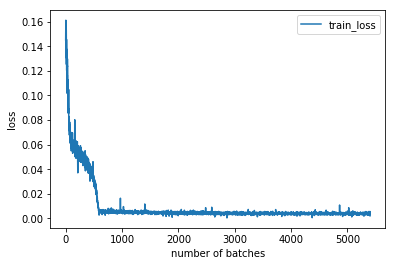

<Figure size 432x288 with 0 Axes>

In [8]:
#train_loss曲线  
x = np.linspace(0,len(train_log),len(train_log))  
plt.plot(x,train_log,label="train_loss",linewidth=1.5)  
plt.xlabel("number of batches")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('train_loss.jpg')  

### rmse、mae、mape的曲线图

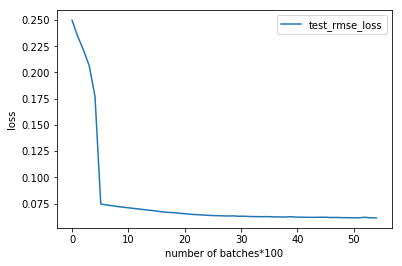

<Figure size 432x288 with 0 Axes>

In [9]:
#test_loss曲线  
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_rmse_loss.jpg')  

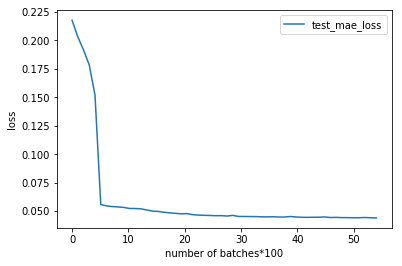

<Figure size 432x288 with 0 Axes>

In [10]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mae_loss.jpg') 

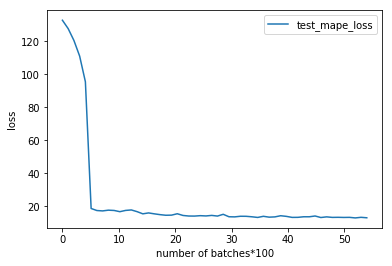

<Figure size 432x288 with 0 Axes>

In [11]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mape_loss.jpg') 